In [8]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers

import numpy as np
import tensorflow as tf
import gymnasium as gym
import scipy.signal
import matplotlib.pyplot as plt

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

# Hyperparameters & Environment

In [13]:
# Environment Hyperparameters
ENV_DELTA_T = 0.01
ENV_MAX_STEPS = 1440
ENV_LATENCY = 20
# ENV ACTIONS
ENV_A_UPPER_BOUND = np.pi
ENV_A_LOWER_BOUND = 0


# Hyperparameters of the PPO algorithm
EPISODES = 30
GAMMA = 0.99
CLIP_RATIO = 0.2
POLICY_LEARNING_RATE = 3e-4
VALUE_FUNCTION_LEARNING_RATE = 1e-3
TRAIN_POLICY_ITERATIONS = 80
TRAIN_VALUE_ITERATIONS = 80
LAMBDA = 0.97
TARGET_KL = 0.01
HIDDEN_LAYER_SIZES = (64, 64)

# True if you want to render the environment
RENDER = False

## Environment

In [5]:
# # Initialize the environment and get the dimensionality of the
# # observation space and the number of possible actions
# env = gym.make("CartPole-v1")
# observation_dimensions = env.observation_space.shape[0]
# num_actions = env.action_space.n

In [14]:
env = SimpleControlledFixedEnv(noise_model='sinusoidal', sinusoidal_components=1, seed = 7)
# print(env.delta_t)
# env.max_t = 2
env.delta_t = ENV_DELTA_T
env.fixed_error_ctrl_pump = [0, 0, 0, 0]
env.fixed_error_ctrl_alice = [np.pi, 0, 0, 0]
env.fixed_error_ctrl_bob = [0, 0, 0, 0]
env.fixed_errors_flags = [True, True, True, True, 
                          False, False, True, True, 
                          True, True, True, True]
env.latency = ENV_LATENCY
env.max_t = ENV_MAX_STEPS*ENV_DELTA_T

## Env testing

Base reward: -826.669466436245


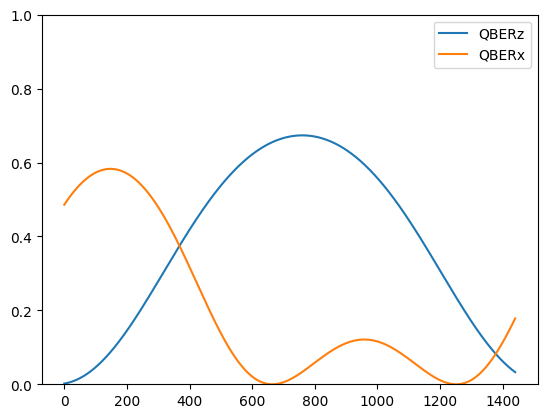

In [17]:
state = env.reset()
done = False
baseline_reward = 0
while not done:
    state, reward, done = env.step()
    baseline_reward += reward
    if done:
        break

plt.ylim(0, 1)
plt.plot(env.qber_history)
plt.legend(['QBERz', 'QBERx'])
print("Base reward:", baseline_reward)

# Definitions

In [2]:
def discounted_cumulative_sums(x, discount):
    # Discounted cumulative sums of vectors for computing rewards-to-go and advantage estimates
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Buffer:
    # Buffer for storing trajectories
    def __init__(self, observation_dimensions, size, gamma=0.99, lam=0.95):
        # Buffer initialization
        self.observation_buffer = np.zeros(
            (size, observation_dimensions), dtype=np.float32
        )
        self.action_buffer = np.zeros(size, dtype=np.int32)
        self.advantage_buffer = np.zeros(size, dtype=np.float32)
        self.reward_buffer = np.zeros(size, dtype=np.float32)
        self.return_buffer = np.zeros(size, dtype=np.float32)
        self.value_buffer = np.zeros(size, dtype=np.float32)
        self.logprobability_buffer = np.zeros(size, dtype=np.float32)
        self.gamma, self.lam = gamma, lam
        self.pointer, self.trajectory_start_index = 0, 0

    def store(self, observation, action, reward, value, logprobability):
        # Append one step of agent-environment interaction
        self.observation_buffer[self.pointer] = observation
        self.action_buffer[self.pointer] = action
        self.reward_buffer[self.pointer] = reward
        self.value_buffer[self.pointer] = value
        self.logprobability_buffer[self.pointer] = logprobability
        self.pointer += 1

    def finish_trajectory(self, last_value=0):
        # Finish the trajectory by computing advantage estimates and rewards-to-go
        path_slice = slice(self.trajectory_start_index, self.pointer)
        rewards = np.append(self.reward_buffer[path_slice], last_value)
        values = np.append(self.value_buffer[path_slice], last_value)

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantage_buffer[path_slice] = discounted_cumulative_sums(
            deltas, self.gamma * self.lam
        )
        self.return_buffer[path_slice] = discounted_cumulative_sums(
            rewards, self.gamma
        )[:-1]

        self.trajectory_start_index = self.pointer

    def get(self):
        # Get all data of the buffer and normalize the advantages
        self.pointer, self.trajectory_start_index = 0, 0
        advantage_mean, advantage_std = (
            np.mean(self.advantage_buffer),
            np.std(self.advantage_buffer),
        )
        self.advantage_buffer = (self.advantage_buffer - advantage_mean) / advantage_std
        return (
            self.observation_buffer,
            self.action_buffer,
            self.advantage_buffer,
            self.return_buffer,
            self.logprobability_buffer,
        )


def mlp(x, sizes, activation=keras.activations.tanh, output_activation=None):
    # Build a feedforward neural network
    for size in sizes[:-1]:
        x = layers.Dense(units=size, activation=activation)(x)
    return layers.Dense(units=sizes[-1], activation=output_activation)(x)


def logprobabilities(logits, a):
    # Compute the log-probabilities of taking actions a by using the logits (i.e. the output of the actor)
    logprobabilities_all = tf.nn.log_softmax(logits)
    logprobability = tf.reduce_sum(
        tf.one_hot(a, num_actions) * logprobabilities_all, axis=1
    )
    return logprobability


# Sample action from actor
@tf.function
def sample_action(observation):
    logits = actor(observation)
    action = tf.squeeze(
        tf.random.categorical(logits, 1), axis=1
    )
    return logits, action


# Train the policy by maxizing the PPO-Clip objective
@tf.function
def train_policy(
    observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        ratio = tf.exp(
            logprobabilities(actor(observation_buffer), action_buffer)
            - logprobability_buffer
        )
        min_advantage = tf.where(
            advantage_buffer > 0,
            (1 + clip_ratio) * advantage_buffer,
            (1 - clip_ratio) * advantage_buffer,
        )

        policy_loss = -tf.reduce_mean(
            tf.minimum(ratio * advantage_buffer, min_advantage)
        )
    policy_grads = tape.gradient(policy_loss, actor.trainable_variables)
    policy_optimizer.apply_gradients(zip(policy_grads, actor.trainable_variables))

    kl = tf.reduce_mean(
        logprobability_buffer
        - logprobabilities(actor(observation_buffer), action_buffer)
    )
    kl = tf.reduce_sum(kl)
    return kl


# Train the value function by regression on mean-squared error
@tf.function
def train_value_function(observation_buffer, return_buffer):
    with tf.GradientTape() as tape:  # Record operations for automatic differentiation.
        value_loss = tf.reduce_mean((return_buffer - critic(observation_buffer)) ** 2)
    value_grads = tape.gradient(value_loss, critic.trainable_variables)
    value_optimizer.apply_gradients(zip(value_grads, critic.trainable_variables))

In [ ]:
buffer = Buffer(observation_dimensions, ENV_MAX_STEPS)
# Initialize the actor and the critic as keras models
observation_input = keras.Input(shape=(observation_dimensions,), dtype="float32")
logits = mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [num_actions])
actor = keras.Model(inputs=observation_input, outputs=logits)
value = tf.squeeze(mlp(observation_input, list(HIDDEN_LAYER_SIZES) + [1]), axis=1)
critic = keras.Model(inputs=observation_input, outputs=value)

# Initialize the policy and the value function optimizers
policy_optimizer = keras.optimizers.Adam(learning_rate=POLICY_LEARNING_RATE)
value_optimizer = keras.optimizers.Adam(learning_rate=VALUE_FUNCTION_LEARNING_RATE)

# Initialize the observation, episode return and episode length
observation, _ = env.reset()
episode_return, episode_length = 0, 0

# Training Loop

In [5]:
from tqdm import tqdm
pbar = tqdm(range(epochs))

rewards = []

# Iterate over the number of epochs
for epoch in pbar:
    # Initialize the sum of the returns, lengths and number of episodes for each epoch
    sum_return = 0
    sum_length = 0
    num_episodes = 0

    # Iterate over the steps of each epoch
    for t in range(steps_per_epoch):
        if render:
            env.render()

        # Get the logits, action, and take one step in the environment
        observation = observation.reshape(1, -1)
        logits, action = sample_action(observation)
        observation_new, reward, done, _, _ = env.step(action[0].numpy())
        episode_return += reward
        episode_length += 1

        # Get the value and log-probability of the action
        value_t = critic(observation)
        logprobability_t = logprobabilities(logits, action)

        # Store obs, act, rew, v_t, logp_pi_t
        buffer.store(observation, action, reward, value_t, logprobability_t)

        # Update the observation
        observation = observation_new

        # Finish trajectory if reached to a terminal state
        terminal = done
        if terminal or (t == steps_per_epoch - 1):
            last_value = 0 if done else critic(observation.reshape(1, -1))
            buffer.finish_trajectory(last_value)
            sum_return += episode_return
            sum_length += episode_length
            num_episodes += 1
            observation, _ = env.reset()
            episode_return, episode_length = 0, 0
            rewards.append(sum_return / num_episodes)

    # Get values from the buffer
    (
        observation_buffer,
        action_buffer,
        advantage_buffer,
        return_buffer,
        logprobability_buffer,
    ) = buffer.get()

    # Update the policy and implement early stopping using KL divergence
    for _ in range(train_policy_iterations):
        kl = train_policy(
            observation_buffer, action_buffer, logprobability_buffer, advantage_buffer
        )
        if kl > 1.5 * target_kl:
            # Early Stopping
            break

    # Update the value function
    for _ in range(train_value_iterations):
        train_value_function(observation_buffer, return_buffer)

    # Print mean return and length for each epoch
    pbar.set_description(f"Mean Return: {sum_return / num_episodes:.2f}. Mean Length: {sum_length / num_episodes:.2f}")

Mean Return: 4000.00. Mean Length: 4000.00: 100%|██████████| 30/30 [03:17<00:00,  6.57s/it]


# Plots

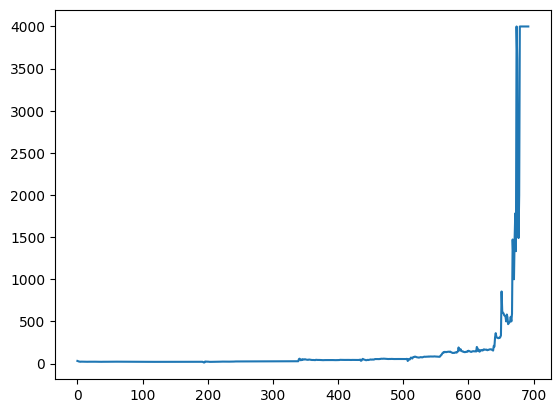

In [6]:
import matplotlib.pyplot as plt

plt.plot(rewards)